In [1]:
import pymoo as moo
import pandas as pd
import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMap
from folium.features import DivIcon
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import utm
import osmnx as ox
import networkx as next
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
import copy
import pickle

In [2]:
class NonSectionedRoute(ElementwiseProblem):
    def __init__(self,x,y,D,maxdistance,tires,includedis,**kwargs):
        n_points = len(x)
        self.maxdist = maxdist


In [4]:
class RecolectionRoute(ElementwiseProblem):

    def __init__(self, x,y,D,maxdist,tires,inclustdis,**kwargs):
   
        n_points = len(x)
        self.maxdist = maxdist
        #self.xini=xini
        #self.yini=yini

        self.x = x
        self.y = y
        self.tires = tires
        self.D = D
        self.inclustdis = inclustdis
        self.cities=np.column_stack((x, y))
        self.max = len(x)

        super(RecolectionRoute, self).__init__(
            n_var=n_points,
            n_obj=1,
            xl=0,
            xu=n_points,
            vtype=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = self.get_route_neumatics(x)
        #out["G"] = self.get_route_neumatics(x)
        #print(out['F'],out['G'])


    def get_route_length(self, x):
        n_points = len(x)
        dist = 0
        param = 0
        for k in range(n_points - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
            param = k
            if (dist >= self.maxdist):
                #print('break')
                break
        self.max = param

    

        last, first = x[k], x[0]
        dist += self.D[last, -1]  # back to the initial recolection point
        dist += self.D[first, -1]
        return dist

    def get_route_neumatics(self, x):
        n_points = len(x)
        dist = 0
        q = 0
        for k in range(n_points - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]/60.0 
            q = q +  (self.tires[k] + self.tires[k + 1])*0.5
            dist += 2.3*(self.tires[k] + self.tires[k + 1])*0.5 +self.inclustdis[k]
            param = k
            
            if (dist >= self.maxdist):
                break
            self.max = param
        return -q





In [5]:
def visualize(problem, x, fig=None, ax=None, show=True, label=True):
    with plt.style.context('ggplot'):

        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # plot cities using scatter plot
        ax.scatter(problem.x, problem.y, s=250,alpha=0.3)
        if label:
            # annotate cities
            for i, c in enumerate(problem.cities):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")


        # plot the line on the path
        for i in range(problem.max):
            current = x[i]
            next_ = x[(i + 1) % len(x)]
            ax.plot(problem.cities[[current, next_], 0], problem.cities[[current, next_], 1], 'g--')

        fig.suptitle("Route length: %.4f" % problem.get_route_length(x))

        if show:
            fig.show()
    return fig


In [6]:
def inform(problem, x):
    retvec = []
    retdist = []
    rettires = []
    for i in range(problem.max + 1):
        retvec.append(x[i])
    for i in range(problem.max ):        
        retdist.append(problem.D[x[i], x[i+1]]/60.0 + 2.3*(problem.tires[x[i]] + problem.tires[x[i+ 1]])*0.5 + problem.inclustdis[ x[i] ] )
    for i in range(problem.max+1):        
        rettires.append(problem.tires[x[i]])
    return retvec, retdist,rettires


In [7]:
class StartFromZeroRepair(Repair):

    def _do(self, problem, X, **kwargs):
        I = np.where(X == 0)[1]

        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])

        return X



In [8]:
def routeinit():
    centralfile = pd.ExcelFile('../Dataset/Basededatosllantas.xlsx')
    names = centralfile.sheet_names
    PuntoRecoFijo   = pd.read_excel(centralfile,names[0])
    PQRS            = pd.read_excel(centralfile,names[1])
    Vehiculo        = pd.read_excel(centralfile,names[2])
    TamaLlantas     = pd.read_excel(centralfile,names[3])
    TipoLLantas     = pd.read_excel(centralfile,names[4])
    RecoleccionLoca = pd.read_excel(centralfile,names[5])
    hoja2           = pd.read_excel(centralfile,names[6])
    hoja9           = pd.read_excel(centralfile,names[7])
    SRS             = pd.read_excel(centralfile,names[8])
    A = PQRS[PQRS['TOTAL Completas']!=0][['Latitud ','Longitud','TOTAL Completas']]
    A['x'] = A['Latitud ']/1000000
    A['y'] = A['Longitud']/1000000

    A = A[A['x'] > 4 ]
    A = A[A['x'] < 5 ]

    A = A[A['y'] > -75 ]
    A = A[A['y'] < -73 ]

    W = A[['x','y']]
    i=50
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(W)
    T = W.copy()
    T['Cluster'] = kmeans.predict(W)
    T['tires'] = A['TOTAL Completas']
    color = list(mcolors.CSS4_COLORS.values())
    nClusters = i

    T['numtire']=A['TOTAL Completas']

    
    xvec = []
    yvec=[]
    tires = []
    interdist = []
    for i in range(0,nClusters):
        cluster = T[T['Cluster'] == i]
        xs = 0
        ys = 0
        ts = 0
        for j in range(0,len(cluster)):
            print(cluster['x'].iloc[j] , cluster['y'].iloc[j])
            #x, y, s1, s2 = utm.from_latlon( cluster['x'].iloc[j] , cluster['y'].iloc[j] )
            x = cluster['x'].iloc[j]
            y = cluster['y'].iloc[j]
            xs = xs + x
            ys = ys + y
            ts = cluster['tires'].iloc[j]
            #plt.plot(x,y,'go',alpha=0.5)
        interdist.append(len(cluster)*1.32)
        xs = xs/len(cluster)
        ys = ys/len(cluster)
        #plt.plot(xs,ys,'bo',alpha=0.6)
        xvec.append(xs)
        yvec.append(ys)
        tires.append(ts)
        pickle.dump(kmeans, open("classification_model.pkl", "wb"))
    return T, kmeans,xvec,yvec,interdist, tires



In [10]:
T.to_csv("outT.csv")

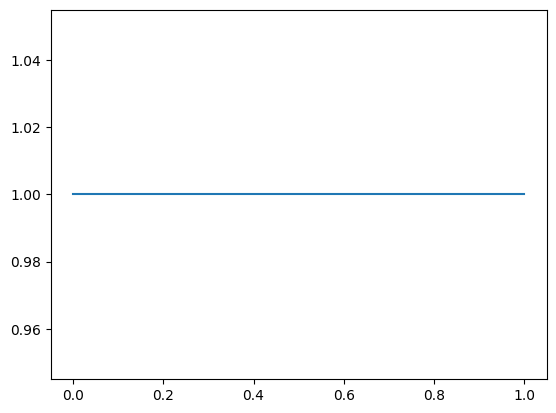

In [9]:
plt.plot([0, 1],[1, 1])
plt.show()

In [9]:
for i in range (0,len(xvec)): 
    print(i," : ",xvec[i],yvec[i])

0  :  4.576240700000001 -74.1065837
1  :  4.685672428571428 -74.06096214285715
2  :  4.595114857142856 -74.17145792857143
3  :  4.712055166666667 -74.10901483333333
4  :  4.748133499999999 -74.05152
5  :  4.615858666666666 -74.08444741666666
6  :  4.624067538461539 -74.17930923076923
7  :  4.559488916666667 -74.14107249999999
8  :  4.600532 -74.1462492142857
9  :  4.6964586666666674 -74.12100566666666
10  :  4.7507582 -74.12024820000002
11  :  4.682392 -74.14928317647059
12  :  4.6560797 -74.0767531
13  :  4.648902 -74.1230998
14  :  4.618190625 -74.109697875
15  :  4.593253714285715 -74.0782672857143
16  :  4.586301153846154 -74.119969
17  :  4.688683833333333 -74.09363716666665
18  :  4.592897090909091 -74.10004227272726
19  :  4.509804 -74.104944
20  :  4.546678666666666 -74.11137416666666
21  :  4.762232 -74.0302090909091
22  :  4.741241727272729 -74.10598163636364
23  :  4.638769625 -74.16570425
24  :  4.712842499999999 -74.1341706
25  :  4.630835153846154 -74.19257299999998
26  :

c:\Users\feosp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4.575569 -74.105548
4.576671 -74.108663
4.584454 -74.106231
4.579519 -74.108332
4.578662 -74.108225
4.56502 -74.102134
4.568073 -74.114703
4.58015 -74.105513
4.574015 -74.102115
4.580274 -74.104373
4.685213 -74.046479
4.682983 -74.063733
4.687368 -74.057272
4.68493 -74.065118
4.684757 -74.064291
4.698466 -74.073796
4.67599 -74.056046
4.595298 -74.171624
4.596122 -74.178602
4.596108 -74.169269
4.604275 -74.172851
4.589549 -74.166041
4.590366 -74.174799
4.591526 -74.165216
4.591863 -74.176762
4.596884 -74.175385
4.59578 -74.161963
4.5942 -74.172734
4.59589 -74.174368
4.595574 -74.163436
4.598173 -74.177361
4.714037 -74.115919
4.714371 -74.116253
4.71026 -74.111462
4.719279 -74.093529
4.707282 -74.10724
4.707102 -74.109686
4.745856 -74.063052
4.753607 -74.057286
4.754243 -74.045433
4.737042 -74.047964
4.753139 -74.047234
4.751838 -74.046692
4.739969 -74.057425
4.75385 -74.057398
4.748932 -74.047512
4.748729 -74.050169
4.743697 -74.04716
4.7467 -74.050915
4.615794 -74.086009
4.61573 -74.08

C:\Users\feosp\AppData\Local\Temp\ipykernel_15688\3343220849.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0, 46, 5, 32, 44, 42, 43]
   points
0       0
1      46
2       5
3      32
4      44
5      42
6      43
[67.95333333333333, 62.584999999999994, 45.70666666666666, 30.25, 56.88166666666667, 104.41833333333332, 0.0]
[27, 14, 19, 1, 4, 32, 24]


C:\Users\feosp\AppData\Local\Temp\ipykernel_15688\3343220849.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0, 29, 33, 26, 20, 15, 10]
   points
0       0
1      29
2      33
3      26
4      20
5      15
6      10
[93.05333333333331, 94.35999999999999, 104.42666666666666, 94.60666666666665, 70.87333333333333, 63.165000000000006, 0.0]
[10, 56, 16, 53, 18, 20, 20]


C:\Users\feosp\AppData\Local\Temp\ipykernel_15688\3343220849.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0, 12, 11, 10, 5, 13]
   points
0       0
1      12
2      11
3      10
4       5
5      13
[69.72666666666666, 100.51999999999998, 67.97166666666666, 32.45, 51.35666666666667, 0.0]
[7, 29, 34, 1, 9, 10]


C:\Users\feosp\AppData\Local\Temp\ipykernel_15688\3343220849.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0, 7, 17, 24, 18]
   points
0       0
1       7
2      17
3      24
4      18
[62.71, 21.906666666666666, 59.57833333333333, 82.02833333333334, 0.0]
[30, 2, 2, 31, 11]


C:\Users\feosp\AppData\Local\Temp\ipykernel_15688\3343220849.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0, 18, 22, 11, 9, 1]
   points
0       0
1      18
2      22
3      11
4       9
5       1
[174.015, 189.67333333333332, 116.80333333333333, 110.57333333333332, 104.73666666666666, 0.0]
[33, 89, 60, 18, 57, 21]


C:\Users\feosp\AppData\Local\Temp\ipykernel_15688\3343220849.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0, 9, 11, 16, 3, 18]
   points
0       0
1       9
2      11
3      16
4       3
5      18
[86.08, 64.595, 42.21333333333334, 101.55666666666666, 134.885, 0.0]
[35, 20, 13, 2, 60, 25]


C:\Users\feosp\AppData\Local\Temp\ipykernel_15688\3343220849.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0, 5, 7, 11, 8, 6, 10]
   points
0       0
1       5
2       7
3      11
4       8
5       6
6      10
[43.75, 64.16833333333334, 51.068333333333335, 25.008333333333333, 45.510000000000005, 80.29666666666665, 0.0]
[6, 2, 21, 5, 2, 13, 32]


C:\Users\feosp\AppData\Local\Temp\ipykernel_15688\3343220849.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0, 5, 2, 3, 4]
   points
0       0
1       5
2       2
3       3
4       4
[150.80166666666665, 95.64833333333333, 104.91666666666667, 113.77499999999999, 0.0]
[48, 38, 28, 21, 38]


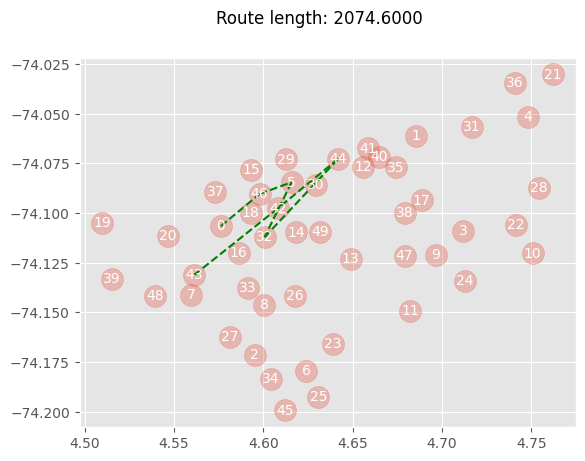

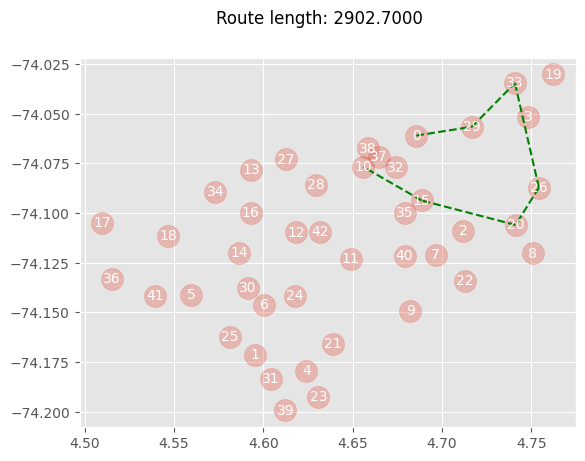

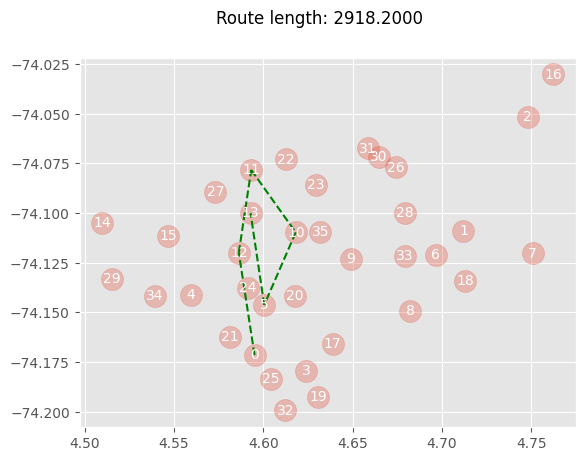

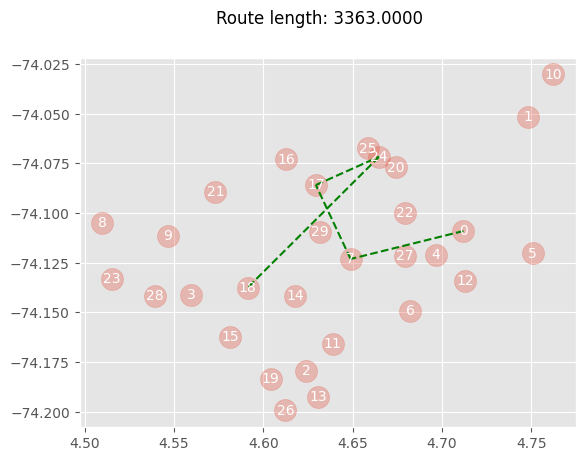

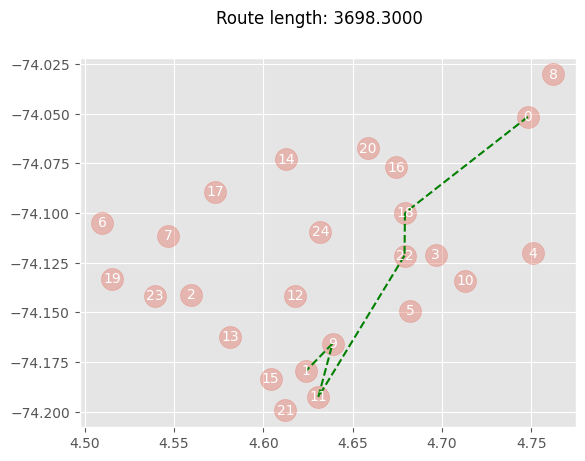

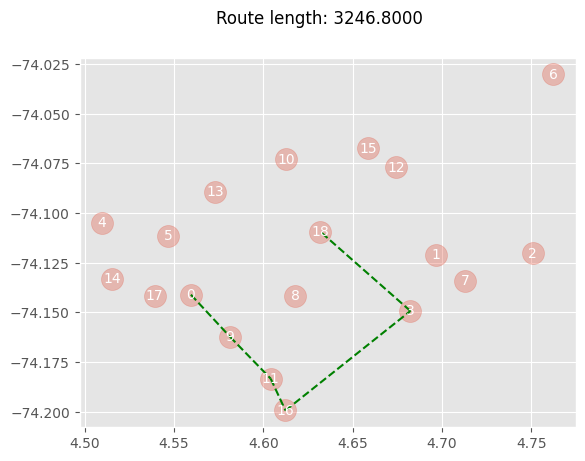

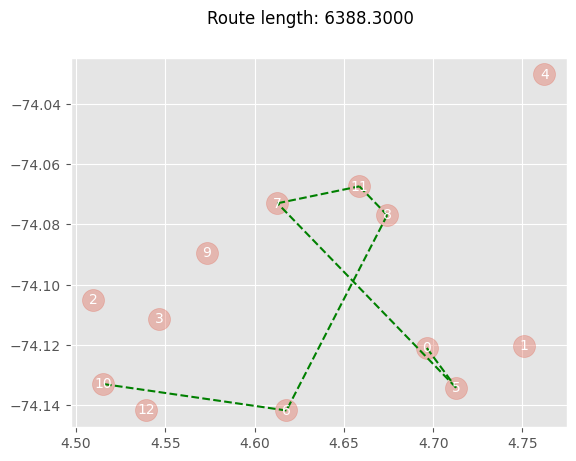

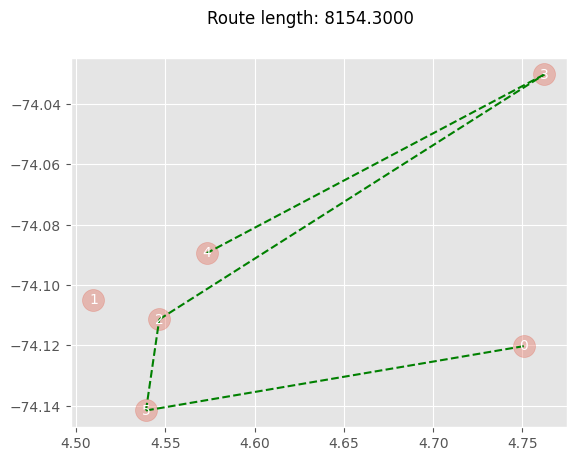

In [10]:
def routeopt(maxtime,tires,xvec,yvec,interdist):
    Dmat = np.loadtxt('outfileDmat.txt')
    xpart, ypart, s1, s2 = utm.from_latlon( -74.10622205211465,4.710107141594455 )
    Dmatcopy = copy.deepcopy(Dmat)
    xvecn     =copy.deepcopy(xvec)
    yvecn=copy.deepcopy(yvec)
    tiresn=copy.deepcopy(tires)
    
    interdistn=copy.deepcopy(interdist)
    routesvec  = []
    s = 0
    clust = list(np.arange(len(yvec)))
    while len(xvecn) > 5:

        problem = RecolectionRoute(xvecn,yvecn,Dmatcopy,maxtime,tiresn,interdistn)

        algorithm = GA(
            pop_size=4000,
            sampling=PermutationRandomSampling(),
            mutation=InversionMutation(),
            crossover=OrderCrossover(),
            repair=StartFromZeroRepair(),
            eliminate_duplicates=True
        )

        # if the algorithm did not improve the last 200 generations then it will terminate (and disable the max generations)
        termination = DefaultSingleObjectiveTermination(period=50, n_max_gen=np.inf)

        res = minimize(
            problem,
            algorithm,
            termination,
            seed=98
        )

        route, dist, tires = inform(problem, res.X)
        dist.append(0.0)
        figure = visualize(problem, res.X)
        figure.savefig("output"+str(s)+".png")
        #route.sort(reverse=True)
        data = pd.DataFrame(route,columns=['points'])

        print(route)
        print(data)

        print(dist)

        print(tires)

        data['x']=data['points'].map(lambda x: xvec[x])
        data['y']=data['points'].map(lambda x: yvec[x])
        data['cluster']=data['points'].map(lambda x: clust[x])
        data['tires']= tires
        data['distance']=dist
        data['case'] = s

        
                        
        s = s + 1
        route.sort(reverse=True)
        for i in range(len(route)):
            xvecn.pop(route[i])
            yvecn.pop(route[i])
            clust.pop(route[i])
            #Dmatcopy
            Dmatcopy = np.delete(Dmatcopy, route[i], 0)
            Dmatcopy = np.delete(Dmatcopy, route[i], 1)
            tiresn.pop(route[i])
            interdistn.pop(route[i])
        routesvec.append(data)

    return routesvec

T, kmeans,xvec,yvec,interdist, tires = routeinit()

routesvec  = routeopt(600,tires,xvec,yvec,interdist)


In [11]:
outtab =  pd.concat(routesvec)


In [13]:
outtab.to_excel('outtab.xlsx')

In [15]:
outtabf =outtab.groupby('case').sum()
outtabf = outtabf.reset_index()

In [16]:
outtabf

,case,points,x,y,cluster,tires,distance
0,0,212,32.202435,-518.694801,212,121,367.795000
1,1,133,32.288961,-518.768667,147,193,520.485000
2,2,51,27.930231,-444.660415,73,90,322.025000
3,3,66,23.130153,-370.575506,119,76,226.223333
4,4,61,27.974903,-444.643859,143,278,695.801667
5,5,57,27.846345,-444.705899,173,155,429.330000
6,6,47,32.409338,-518.927193,203,81,309.801667
7,7,14,23.247403,-370.523024,136,173,465.141667


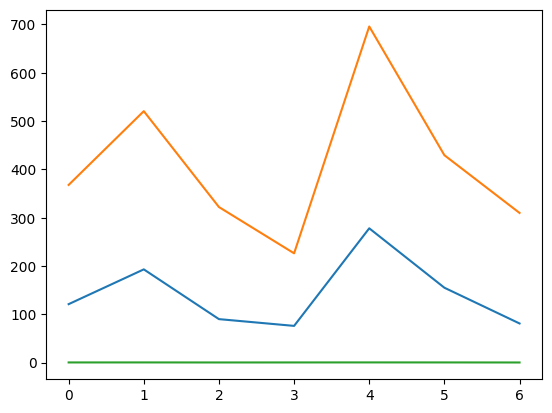

In [59]:

outtires = [] 
outdistance = []
cases = []
for i in range(0,7):
    valuet = sum(list(outtab[outtab['case'] == i ]['tires']))
    valued = sum(list(outtab[outtab['case'] == i ]['distance']))
    outtires.append(float(valuet))
    outdistance.append(float(valued))
    cases.append(i)
outtires = np.array(outtires)
outdistance = np.array(outdistance)
#floats = [float(x) for x in ints] 

#fig = plt.plot

plt.plot(cases,outtires)
plt.plot(cases,outdistance)
plt.plot(cases,outtires/outdistance)
plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt

def implicit_simulator(corner_point_grid, boundary_conditions, initial_conditions):

  # Get the number of elements in each direction
  nx = corner_point_grid.shape[0]
  ny = corner_point_grid.shape[1]

  # Create a grid
  grid = fem.Grid(corner_point_grid)

  # Create a space
  space = space.P1(grid)

  # Create dofs
  dofs = space.dof_handler(grid)

  # Create a function space
  function_space = fem.FunctionSpace(space)

  # Create a solution
  solution = function_space.solution()

  # Set the values of the solution at the corner points
  for i in range(nx):
    for j in range(ny):
      solution.vector()[i * (ny + 1) + j] = corner_point_grid[i, j]

  # Set the values of the solution at the boundary
  for i in range(nx):
    dofs[i * (ny + 1)] = boundary_conditions[0]
    dofs[i * (ny + 1) + ny] = boundary_conditions[1]
  for j in range(ny):
    dofs[j] = boundary_conditions[2]
    dofs[(nx + 1) * j] = boundary_conditions[3]

  # Iterate over the elements in the mesh
  for i in range(1, nx - 1):
    for j in range(1, ny - 1):

      # Get the values of the solution at the four corners of the element
      top_left = solution.vector()[i * (ny + 1) + j]
      top_right = solution.vector()[(i + 1) * (ny + 1) + j]
      bottom_left = solution.vector()[i * (ny + 1) + j + 1]
      bottom_right = solution.vector()[(i + 1) * (ny + 1) + j + 1]

      # Create a system of equations
      system_of_equations = [
          fem.eqn(solution.vector()[i * (ny + 1) + j + 1] == (top_left + top_right + bottom_left + bottom_right) / 4),
          fem.eqn(solution.vector()[i * (ny + 1) + j + 1] >= 0),
      ]

      # Solve the system of equations
      fem.solver.solve(system_of_equations)

  # Return the solution
  return solution

def main():

  # Define the domain
  nx = 100
  ny = 100
  corner_point_grid = np.zeros((nx + 1, ny + 1))
  for i in range(nx):
    corner_point_grid[i, 0] = 0
    corner_point_grid[i, ny] = 1
  for j in range(ny):
    corner_point_grid[0, j] = 0
    corner_point_grid[nx, j] = 1

  # Define the boundary conditions
  boundary_conditions = [0, 1, 0, 1]

  # Define the initial conditions
  initial_conditions = corner_point_grid

  # Solve the problem
  solution = implicit_simulator(corner_point_grid, boundary_conditions, initial_conditions)

  # Plot the solution
  plt.imshow(solution.vector(), origin='lower', extent=[0, nx, 0, ny])
  plt.show()

if __name__ == '__main__':
  main()


NameError: name 'fem' is not defined

In [40]:
plt.plot(cases,outtires/max(outtires))

In [ ]:
https://www.google.com/maps/dir/4.710107,-74.10622/'4.5979440000,-74.0903800000'/'4.5912940000000000,-74.1374850000000000'/'4.6181910000,-74.1096980000'/'4.5762410000,-74.1065840000'/'4.71010714159445000,-74.10622205211460000'

In [ ]:
https://www.google.com/maps/dir/4.710107,-74.10622/'4.5979440000,-74.0903800000'/'4.5912940000000000,-74.1374850000000000'/'4.6181910000,-74.1096980000'/'4.5762410000,-74.1065840000'/'4.71010714159445000,-74.10622205211460000'

In [ ]:
https://www.google.com/maps/dir/4.710107,-74.10622/'4.59215000,-74.08976600'/'4.59814700,-74.09278800'/'4.59854500,-74.09333100'/'4.59844200,-74.09076900'/'4.59884200,-74.09065700'/'4.59594500,-74.13403800'/'4.59594500,-74.13749800'

In [ ]:
https://www.google.com/maps/dir/4.710107,-74.10622/'4.5979440000,-74.0903800000'/'4.5912940000000000,-74.1374850000000000'/'4.6181910000,-74.1096980000'/'4.5762410000,-74.1065840000'/'4.71010714159445000,-74.10622205211460000'/'4.5979440000,-74.0903800000'/'4.5912940000000000,-74.1374850000000000'/'4.6181910000,-74.1096980000'/'4.5762410000,-74.1065840000'/'4.71010714159445000,-74.10622205211460000'/'4.59215000,-74.08976600'/'4.59814700,-74.09278800'/'4.59854500,-74.09333100'/'4.59844200,-74.09076900'/'4.59884200,-74.09065700'/'4.59594500,-74.13403800'/'4.59594500,-74.13749800'